In [6]:
%matplotlib inline

In [7]:
#######################################################  
# Universidade Federal do Piauí                       #
# Campus ministro petronio Portela                    #                                       
# Copyright 2021 -José Borges do Carmo Neto-          #
# @author José Brges do Carmo Neto                    #
# @email jose.borges90@hotmail.com                    #
#  -- Rede Bayseana                                   #
#  -- Version: 1.0  - 30/10/2021                      #
#######################################################    


Atividade(2.5): Realizar a classificação com a Rede Bayesiana:
<ol>
    <li> O método predict deve ser criado na classe BNEstimator(). Tal método deve receber um conjunto de teste e retornar a acurácia. </li> 
    <li> Testar um algoritmo de aprendizado diferente do GreedyHillClimbing, plotar a curva de aprendizado dos algoritmos (erro vs iterações) e comparar os resultados obtidos pela rede com os diferentes algoritmos. </li> 
    <li> Verificar uma nova hipótese: P(semi_intesive | evidencia). Nota: covid_19 deve se relacionar com a variável semi_intensiva. </li> 
</ol>

# Tratamento dos Dados

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time

## Carregando os dados

In [9]:
data = pd.read_excel('covid19.xlsx')

In [10]:
data.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratando os Dados

In [11]:
# Renomear colunas com nomes extensos
data.rename(columns= {'Patient age quantile': 'age_quantile',
                   'SARS-Cov-2 exam result': 'covid_19',
                   'Patient addmited to regular ward (1=yes, 0=no)': 'regular_ward', 
                   'Patient addmited to semi-intensive unit (1=yes, 0=no)': 'semi_intensive_care',
                   'Patient addmited to intensive care unit (1=yes, 0=no)': 'intensive_care',
                   'Influenza B, rapid test': 'influenza_B_rapid_test',
                   'Influenza A, rapid test': 'influenza_A_rapid_test'}, inplace = True)

# Transformar a variável categórica 
label_encoder = LabelEncoder()
data['covid_19'] = label_encoder.fit_transform(data['covid_19'])

# Remover os IDs dos pacientes
data.drop(columns = 'Patient ID', inplace = True)


In [12]:
data.head()

,age_quantile,covid_19,regular_ward,semi_intensive_care,intensive_care,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Remover a coluna onde mais de 95% dos dados são NaNs 
thresh = 0.05*data.shape[0]
data.dropna(axis= 1, thresh=thresh, inplace = True)

# Remover todas as colunas que têm apenas um valor
counts = data.nunique(axis=0)
index = counts[counts.values == 1].index
data.drop(columns = index, inplace = True)

# Considerar apenas as colunas q assumem no máximo 4 valores, com excessão de 4 V.As contínuas
kept_cols = [i for i in data if data[i].nunique()<=4]
kept_cols.extend(['Platelets','Red blood Cells','Lymphocytes','Leukocytes'])
data = data[kept_cols]

## Manipulando os dados faltantes
continuous_cols = [x for x in data.columns if data[x].dtypes == 'float64']
discrete_cols = [x for x in data.columns if (data[x].dtypes == 'O') | (data[x].dtypes == 'int64') | (data[x].dtypes == 'int32')]
print("Dados Contínuos: ", continuous_cols, "\nDados discretos:", discrete_cols)

#Remover os targets da listas das colunas onde os NaNs serão substituídos 
for i in ['covid_19', 'regular_ward', 'semi_intensive_care','intensive_care']:
    discrete_cols.remove(i) 

# Substituindo os NaNs dos dados contínuos pela média    
for i in continuous_cols:     
    data[i].fillna(data[i].median(), inplace=True) 
            
# Substituindo os NaNs dos dados discretos pelo inteiro '-999' 
for i in discrete_cols:     
    data[i].fillna('-999', inplace=True) 

Dados Contínuos:  ['Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes'] 
Dados discretos: ['covid_19', 'regular_ward', 'semi_intensive_care', 'intensive_care', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'influenza_B_rapid_test', 'influenza_A_rapid_test', 'Strepto A']


In [14]:
data.to_csv('template.csv', index = False)

# Criando a Rede Beyesiana

In [15]:
pip install pydotplus

In [16]:
pip install pyagrum

     |████████████████████████████████| 4.9 MB 1.1 MB/s 


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

A rede criada já conta com o método predict solicitado na atividade

In [18]:
class BNEstimator():

    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
        

    def transform(self,d):

        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d

    def fit(self,data,name_file):

        learner = gum.BNLearner(name_file, data)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        if self.learning_method == 'tabu':learner.useLocalSearchWithTabuList()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
        
        @np.vectorize
        def pseudolog(x):
            seuil=2.0
            y=-x if x<0 else x
                  
            if y<seuil:
                res=y*np.log10(seuil)/seuil
            else:
                res=np.log10(y)
                  
            return res if x>0 else -res

        gnb.animApproximationScheme(learner) # scale by default is np.log10  

        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())

        return self

   


        
    
    def predict(self,test):

      tamanho_test_ = test.loc[:,:].shape[0]
      self.y_true = np.zeros(tamanho_test_)
      self.y_pred = np.zeros(tamanho_test_)

      aie=gum.LazyPropagation(self.bn)

      for i in range(tamanho_test_):
        
        row = test.loc[i,:]
        evs = row.astype(str).to_dict()
        self.y_true[i] = int(evs['covid_19'])
        #del evs['covid_19']
        aie.setEvidence(evs)
        aie.makeInference()
        print(aie.posterior('covid_19')[:])
        self.y_pred[i] = np.argmax(aie.posterior('covid_19')[:])


        self.acuracia  = accuracy_score(self.y_true, self.y_pred)

        return self

In [19]:
# Instanciar o estimador Bayesiano
estimator = BNEstimator('template.csv', class_name='covid_19',
                  tabu_arcs=[('influenza_B_rapid_test', 'covid_19')],
                  mandatory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19')],
                  cut_points_percentiles = [5, 50, 95])

data = pd.read_csv('template.csv')
# Criar a topologia da rede
template,data = estimator.transform(data)

In [20]:
# Divisão treino/teste
train,test = train_test_split(data,test_size=0.20, random_state=42)
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [21]:
# Treinar o modelo
%matplotlib inline
start = time.time()
estimator.fit(template,'train.csv')
end = time.time()
time_treino = end - start

<Figure size 432x288 with 0 Axes>

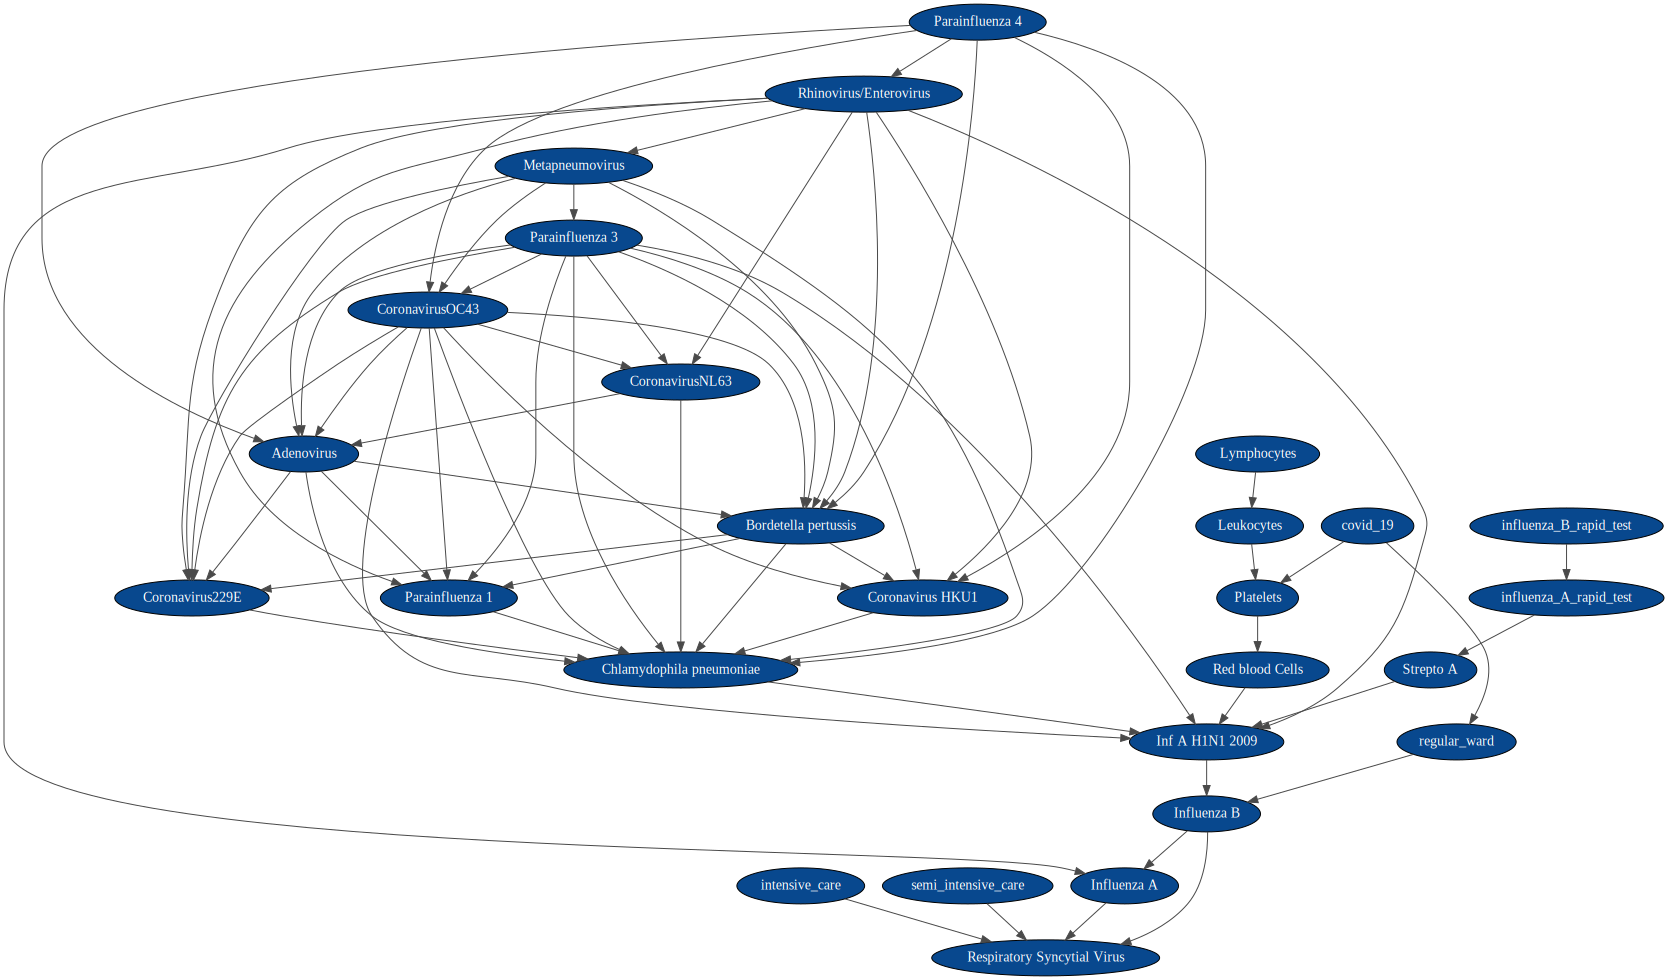

In [22]:
gnb.showBN(estimator.bn,size=60,nodeColor={n:0.91 for n in estimator.bn.names()},cmap=plt.cm.get_cmap('Blues'))

In [23]:
test = pd.read_csv('test.csv')
estimator.predict(test)

[1. 0.]


In [24]:
estimator.acuracia

1.0

In [25]:
results_ghc = [estimator.acuracia,time_treino]

In [26]:
#### Função que retorna acuracia para um conjunto de test

def perd(estimador, test_conj ):
  test = pd.read_csv(test_conj)

  tamanho_test_ = test.loc[:,:].shape[0]

  y_true = np.zeros(tamanho_test_)
  y_pred = np.zeros(tamanho_test_)
  aie=gum.LazyPropagation(estimador)

  for i in range(tamanho_test_):
    
    row = test.loc[i,:]
    evs = row.astype(str).to_dict()
    y_true[i] = int(evs['covid_19'])
    del evs['covid_19']
    aie.setEvidence(evs)
    aie.makeInference()
    y_pred[i] = np.argmax(aie.posterior("covid_19")[:])

  return accuracy_score(y_true, y_pred)

In [27]:
perd(estimator.bn, 'test.csv') 

0.9043401240035429

## Modificações na Rede

Criando uma rede com o algoritmo de aprendizado TabuList.

Para isso foi inserido no método fit a seguinte linha de codigo:

In [28]:
# if self.learning_method == 'tabu':learner.useLocalSearchWithTabuList()

Nesta linha de codigo é feito o teste do valor da variavel self.learning_method. Se o valor atribuido a ela for 'tabu' então a rede utilizara o medtodo de aprendizado TabuList.

In [29]:
# Instanciar o estimador Bayesiano com learner.useLocalSearchWithTabuList()
estimator_tabu = BNEstimator('template.csv', class_name='covid_19',
                  tabu_arcs=[('influenza_B_rapid_test', 'covid_19')],
                  mandatory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19')],
                  cut_points_percentiles = [5, 50, 95], learning_method='tabu')

data = pd.read_csv('template.csv')
# Criar a topologia da rede
template,data = estimator.transform(data)

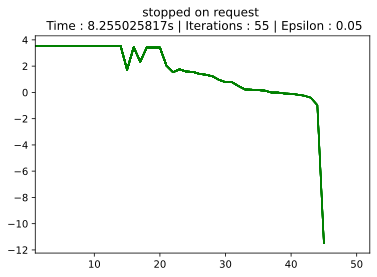

In [30]:
# Treinar o modelo tabu
start = time.time()
estimator_tabu.fit(template,'train.csv')
end = time.time()
time_tabu_treino =  end - start



In [31]:
test = pd.read_csv('test.csv')
estimator_tabu.predict(test)

[1. 0.]


In [32]:
results_tabu = [estimator_tabu.acuracia,time_tabu_treino]

### Resultados comparação 

In [33]:
results_ = pd.DataFrame(np.array([results_ghc, results_tabu]) , columns= ['Acuracia',  'Time'] )
results_.index = ['GreedyHillClimbing','LocalSearchWithTabuList']

In [34]:
results_.head()

,Acuracia,Time
GreedyHillClimbing,1.0,2.041071
LocalSearchWithTabuList,1.0,8.481801


Podemos observar que o Algoritmo LocalSearchWithTabuList é executado em menos tempo e obtem a mesma acuracia de 1.

## Criando a Rede com  hipotese P(semi_intesive | evidencia)

In [35]:
# Instanciar o estimador Bayesiano com learner.useLocalSearchWithTabuList()
estimator_2 = BNEstimator('template.csv', class_name='covid_19',
                  tabu_arcs=[('influenza_B_rapid_test', 'covid_19')],
                  mandatory_arcs=[('Coronavirus HKU1','covid_19'),('Respiratory Syncytial Virus','covid_19'),('semi_intensive_care', 'covid_19')],
                  cut_points_percentiles = [5, 50, 95], learning_method='tabu')

data = pd.read_csv('template.csv')
# Criar a topologia da rede
template,data = estimator_2.transform(data)

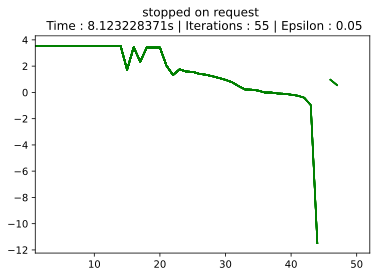

In [36]:
# Treinar o modelo tabu
estimator_2.fit(template,'train.csv')

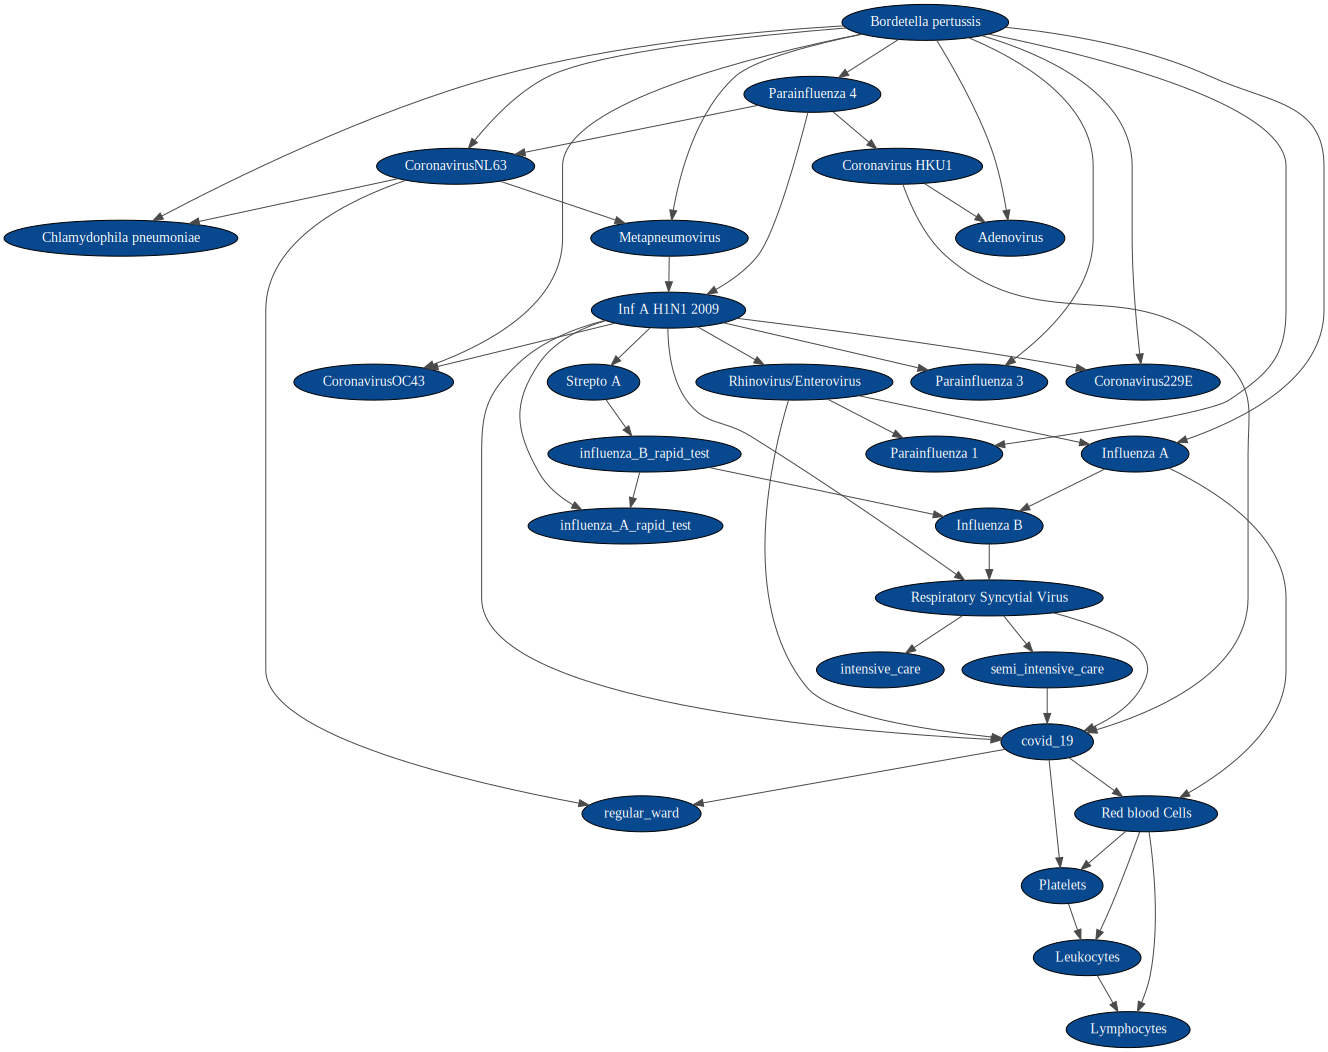

In [37]:
gnb.showBN(estimator_2.bn,size=60,nodeColor={n:0.91 for n in estimator.bn.names()},cmap=plt.cm.get_cmap('Blues'))

In [38]:
#capturar a tabela de probabilidade condicional
estimator_2.bn.cpt(estimator_2.bn.idFromName('covid_19'))

(pyAgrum.Potential<double>@0x556642d4d860) 
                                  ||  covid_19         |
semi_i|Corona|Rhinov|Inf A |Respir||0        |1        |
------|------|------|------|------||---------|---------|
0     |-999  |-999  |-999  |-999  || 0.8953  | 0.1047  |
1     |-999  |-999  |-999  |-999  || 0.8747  | 0.1253  |
0     |not_de|-999  |-999  |-999  || 0.5000  | 0.5000  |
1     |not_de|-999  |-999  |-999  || 0.5000  | 0.5000  |
0     |detect|-999  |-999  |-999  || 0.5000  | 0.5000  |
1     |detect|-999  |-999  |-999  || 0.5000  | 0.5000  |
[...150 more line(s) ...]
0     |-999  |detect|detect|detect|| 0.5000  | 0.5000  |
1     |-999  |detect|detect|detect|| 0.5000  | 0.5000  |
0     |not_de|detect|detect|detect|| 0.5000  | 0.5000  |
1     |not_de|detect|detect|detect|| 0.5000  | 0.5000  |
0     |detect|detect|detect|detect|| 0.5000  | 0.5000  |
1     |detect|detect|detect|detect|| 0.5000  | 0.5000  |

In [39]:
test = pd.read_csv('test.csv')
estimator_2.predict(test)

[1. 0.]


In [40]:
estimator_2.acuracia

1.0

In [41]:
#capturar a tabela de probabilidade condicional
estimator.bn.cpt(estimator.bn.idFromName('covid_19'))

(pyAgrum.Potential<double>@0x556642430580) 
  covid_19         |
0        |1        |
---------|---------|
 0.9002  | 0.0998  |